# Логистика химических продуктов

Задача относится к области моделирования ценообразования на
олигополистических рынках с использованием элементов теории игр. При этом
не требуется каких-то специальных знаний по теории игр, задача решается из
общих соображений.
Рассмотрим гипотетический рынок химического продукта, используемого
в промышленности для изготовления растворителей и синтеза полимеров.
Допустим, что имеется три производителя данного продукта и четыре крупных
покупателя, другие покупатели являются слишком мелкими и их влиянием
можно пренебречь. Предположим, что все три производителя производят
абсолютно одинаковый продукт и у покупателей на внутреннем рынке нет
никаких предпочтений относительно выбора того или иного производителя
кроме цены.
Поставки продукта от производителя покупателям производятся по
железной дороге в цистернах за счет производителя, т.е. расходы на перевозку
прибавляются к расходам производителя. Тариф на перевозку зависит от
расстояния доставки. Каждый производитель может доставить продукт до
любого покупателя, при этом понеся соответствующие расходы за
транспортировку. Также у любого поставщика есть возможность доставить
любое количество своего продукта по железной дороге в морской порт, откуда
его можно продать зарубежным покупателям по некоторой фиксированной цене,
не зависящей от количества продукта (т.е. цена продажи 1 тонны и 10 000 тонн
продукта будет одинаковой). Предположим, что все поставщики действуют
рационально. Также примем, что если один из них может повысить свою
прибыль понизив цену и забрав долю рынка у конкурентов, то он непременно
сделает это. Цена, по которой можно продать продукт в порту, составляет 50
долларов за тонну.
Покупателями продукта на внутреннем рынке являются крупные
промышленные компании. При этом потребности покупателей неэластичны по
цене в диапазоне до 100 долларов за тонну продукта, а при большей цене
покупатели откажутся от покупки. Каждый покупатель приобретает
фиксированное количество продукта каждый месяц. Примем, что покупатель
гарантированно меняет поставщика, если ему предлагается цена на ниже той,
по которой он покупает в настоящее время.
Данные по рынку представлены в таблицах 1-3.

# Задача

 Задача заключается в том, чтобы определить, кто у кого и по каким ценам
будет покупать продукт после того, как рынок придет в состояние равновесия,
т.е. когда ни у кого из производителей не будет мотивации менять цены или
объемы поставок. Важным моментом является то, что необходимо найти именно
верхнюю границу такого равновесия, т.е. набор максимальных возможных
равновесных цен поставок. На рынке, работающем по описанным правилам,
цены сами придут к уровню максимальных, если в начальный момент они были
заведомо больше (скажем, если максимальные равновесные цены находятся в
районе 50 долларов, а в начальный момент времени они были, допустим, 70
долларов).

# Библиотеки

In [48]:
import pandas as pd
import docplex.mp as dpx
import cplex
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

import warnings

warnings.filterwarnings('ignore')

boldText = '\033[1m'

In [49]:
#pip install networkx

# 1. Исходные данные модели

In [50]:
# Данные по поставщикам
NProds = 3            #Количество производителей
NBuyers = 3           #Количество покупателей
d = 50                  #Константная цена товара в Порту
BuyersMaxPrice = 100    #максимальная цена

### 1.1 Производители

In [51]:
ProdIndex=[]
for i in range(NProds):
    ProdIndex.append('P'+ str(i))

Possibilities = np.random.uniform(low=200, high=1500, size=NProds).astype(int)
SupplyPort = np.random.uniform(low=10, high=20, size=NProds).astype(int)
ProdCost = np.random.uniform(low=10, high=30, size=NProds).astype(int)
PortPrice = np.empty(NProds).astype(int)
PortPrice.fill(d)
Overhead = SupplyPort+ProdCost

ProdData = {'Possibilities': Possibilities,
            'SupplyPort': SupplyPort,
            'ProdCost': ProdCost,
            'PortPrice': PortPrice,
            'Overhead': Overhead
             }
Producers = pd.DataFrame(ProdData, ProdIndex)

In [52]:
print(boldText+'Таблица 1. Данные по поставщикам')
Producers

Таблица 1. Данные по поставщикам


,Possibilities,SupplyPort,ProdCost,PortPrice,Overhead
P0,729,18,28,50,46
P1,1214,10,19,50,29
P2,1086,17,19,50,36


In [53]:
#Producers.index

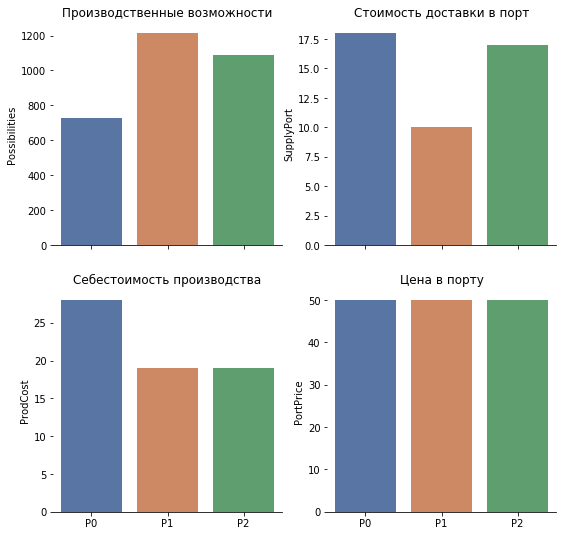

In [54]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), sharex=True)
sns.despine(left=True)

sns.barplot(x=Producers.index,
            y='Possibilities',
            data=Producers,
            palette="deep",
            ax=axes[0, 0]).set_title('Производственные возможности')

sns.barplot(x=Producers.index,
            y='SupplyPort',
            data=Producers,
            palette="deep",
            ax=axes[0, 1]).set_title('Стоимость доставки в порт')

sns.barplot(x=Producers.index,
            y='ProdCost',
            data=Producers,
            palette="deep",
            ax=axes[1, 0]).set_title('Себестоимость производства')

sns.barplot(x=Producers.index,
            y='PortPrice',
            data=Producers,
            palette="deep",
            ax=axes[1, 1]).set_title('Цена в порту')

plt.show()

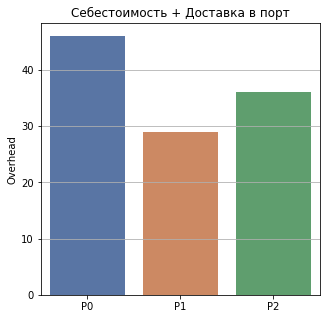

In [55]:
plt.figure(figsize=(5,5))
plt.grid()
plt.title('Себестоимость + Доставка в порт')
sns.barplot(x=Producers.index,
            y='Overhead',
            data=Producers,
            palette="deep")
plt.show()

Чем ниже этот паказатель, тем в более широком диапазоне продавец может варьироваь ценой при поставке продуктов покупателям

### 1.2 Покупатели

In [56]:
# Месячные потребности покупателей, тонн
BuyIndex = []
for j in range(NBuyers):
    BuyIndex.append('B'+ str(j))

Scenario1 = np.random.uniform(low=50, high=200, size=NBuyers).astype(int)
Scenario2 = np.random.uniform(low=150, high=500, size=NBuyers).astype(int)

BuyData = {'Scenario1': Scenario1, 'Scenario2': Scenario2}

Buyers = pd.DataFrame(BuyData, BuyIndex)

In [57]:
print(boldText+'Таблица 2. Месячные потребности покупателей, тонн')
Buyers.head()

Таблица 2. Месячные потребности покупателей, тонн


,Scenario1,Scenario2
B0,170,262
B1,185,335
B2,160,466


In [58]:
#выбор сценария
Scenario = Buyers.columns[0] # 0 - Scenario1
                             # 1 - Scenario2
print(Scenario)

Scenario1


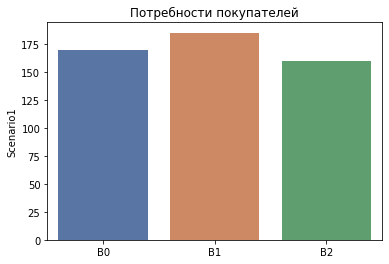

In [59]:
sns.barplot(x=Buyers.index,
            y='Scenario1',
            data=Buyers,
            palette="deep").set_title('Потребности покупателей')
plt.show()

In [60]:
# Тарифы на железнодорожные перевозки
#RailData = {'Producer1':[14,23,21,42], 'Producer2':[26,10,19,36], 'Producer3':[15,38,18,15]}

RailData = np.random.uniform(low=10, high=20, size=(NBuyers, NProds)).astype(int)

RailDataDict = dict(zip(ProdIndex, RailData.T))

RailFares = pd.DataFrame(RailDataDict, BuyIndex)

In [61]:
print(boldText+'Таблица 3. Тарифы на железнодорожные перевозки')
RailFares.head()

Таблица 3. Тарифы на железнодорожные перевозки


,P0,P1,P2
B0,19,14,11
B1,14,14,17
B2,17,18,11


Тарифы на ЖД перевозки


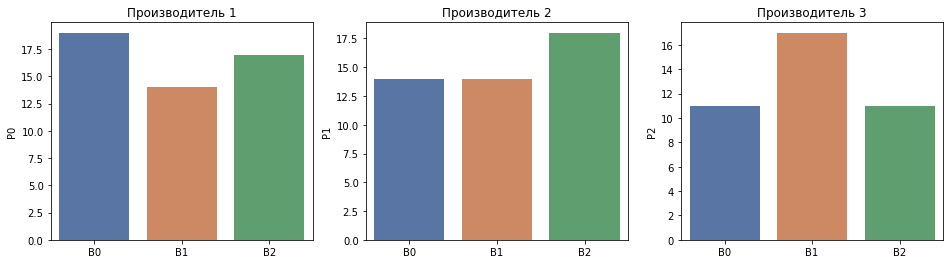

In [62]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharex=True)
#sns.despine(left=True)

sns.barplot(x=RailFares.index,
            y='P0',
            data=RailFares,
            palette="deep",
            ax=axes[0]).set_title('Производитель 1')

sns.barplot(x=RailFares.index,
            y='P1',
            data=RailFares,
            palette="deep",
            ax=axes[1]).set_title('Производитель 2')

sns.barplot(x=RailFares.index,
            y='P2',
            data=RailFares,
            palette="deep",
            ax=axes[2]).set_title('Производитель 3')

print(boldText+'Тарифы на ЖД перевозки')
plt.show()

In [63]:
totCost = RailFares + Producers['ProdCost']

In [64]:
print(boldText+'Тарифы на железнодорожные перевозки + себестоимость производства')
totCost.head()

Тарифы на железнодорожные перевозки + себестоимость производства


,P0,P1,P2
B0,47,33,30
B1,42,33,36
B2,45,37,30


Тарифы на ЖД перевозки + Себестоимость производства


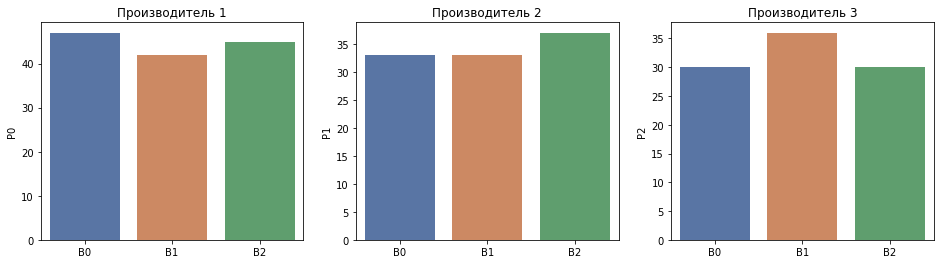

In [65]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharex=True)
#sns.despine(left=True)

sns.barplot(x=totCost.index,
            y='P0',
            data=totCost,
            palette="deep",
            ax=axes[0]).set_title('Производитель 1')

sns.barplot(x=totCost.index,
            y='P1',
            data=totCost,
            palette="deep",
            ax=axes[1]).set_title('Производитель 2')

sns.barplot(x=totCost.index,
            y='P2',
            data=totCost,
            palette="deep",
            ax=axes[2]).set_title('Производитель 3')

print(boldText+'Тарифы на ЖД перевозки + Себестоимость производства')
plt.show()

- Здесь видно, что например, минимальные накладные расходы для доставки товаров второму покупателю имеет второй производитель.
Однако, за счёт большего приимущества первого производителя по накладным расходам доставки продуктов в порт конкурентную борьбу по минимальной предложенной цене выигрывает он.

In [66]:
minCostProd = np.zeros((NProds, NBuyers)).astype(int)
for j in range(NBuyers):
    min_idx = np.argmin(totCost.values[j,:])
    minCostProd[min_idx, j] = totCost.values[j,min_idx]
    #minCostProd.append(totCost.values[j,min_idx])


In [67]:
minCostProd = pd.DataFrame(data=minCostProd, index=totCost.columns, columns=totCost.index)

In [68]:
minCostProd.head()

,B0,B1,B2
P0,0,0,0
P1,0,33,0
P2,30,0,30


In [69]:
# Тарифы на жд перевозки от i-го производителя j-му покупателю + себестоимость производства i-го производителя
k = np.zeros((NProds, NBuyers)).astype(int)
i=0
j=0
for prod, pcost in zip(RailFares, Producers['ProdCost']): # перебор по Producers
    j=0
    for rfares in RailFares[prod]:
        k[i,j] = rfares + pcost
        j+=1
    i+=1

In [70]:
# Тарифы на жд перевозки в порт + себестоимость производства i-го производителя 
z = np.empty(NProds).astype(int)
i=0
for SupplyPort, ProdCost in zip(Producers['SupplyPort'], Producers['ProdCost']):
    z[i] = SupplyPort + ProdCost
    i+=1

In [71]:
print('Тарифы на жд перевозки в порт + себестоимость производства i-го производителя')
print(z[:10])

Тарифы на жд перевозки в порт + себестоимость производства i-го производителя
[46 29 36]


### Минимально выгодная цена для производителей при поставке продуктов покупателям

 - Условие снижение цены для покупателей:
     xij - kij > d - zi
     
 - Минимально выгодная цена для производителей при поставке покупателям:
     xij = d - zi + kij + 1


In [72]:
#Максимальная выгодная цена для продажи
ProdBestPrices = np.zeros((NProds, NBuyers)).astype(int)

In [73]:
for j in range(NBuyers):
    i=0
    for portPrice, supplyPort, supplyProd in zip(Producers['PortPrice'], Producers['SupplyPort'], k[:,j]):
#       print(portPrice, supplyPort, supplyProd)
        ProdBestPrices[i,j] = portPrice-supplyPort+1+supplyProd
        i+=1

In [74]:
print(boldText+'Максимальная выгодные цены для продажи:')
ProdBestPrices[:10]

Максимальная выгодные цены для продажи:


array([[80, 75, 78],
       [74, 74, 78],
       [64, 70, 64]])

In [75]:
#Матрица спроса покупателей
h = np.zeros((NProds, NBuyers)).astype(int)
for j in range(NBuyers):
    min_idxs = np.argmin(ProdBestPrices[:,j])
    h[min_idxs, j] = 1

print(boldText+'Матрица спроса покупателей')
h[:10]

Матрица спроса покупателей


array([[0, 0, 0],
       [0, 0, 0],
       [1, 1, 1]])

# Решение задачи

Задача заключается в том, чтобы определить, кто у кого и по каким ценам
будет покупать продукт после того, как рынок придет в состояние равновесия,
т.е. когда ни у кого из производителей не будет мотивации менять цены или
объемы поставок. Важным моментом является то, что необходимо найти именно
верхнюю границу такого равновесия, т.е. набор максимальных возможных
равновесных цен поставок. На рынке, работающем по описанным правилам,
цены сами придут к уровню максимальных, если в начальный момент они были
заведомо больше (скажем, если максимальные равновесные цены находятся в
районе 50 долларов, а в начальный момент времени они были, допустим, 70
долларов).
Необходимо заполнить таблицу 4 ценами и объемами поставок.

# Построение модели

In [76]:
from docplex.mp.model import Model
mdl = dpx.model.Model("ChemProd")

# Переменные решения

Определим переменные решения:

 - xij – количество тонн продукта поставленное от i-го производителя j-му покупателю;
 - yij – цена за тонну продукта i-го производителя j-му покупателю;
 - pi  – количество продукта перевнзённое от i-го производителя в порт.

In [77]:
# матрица решений, показывающая количество тонн продукта поставленное от i-го производителя j-му покупателю
# столбец-производитель; строка-покупатель
x = mdl.integer_var_matrix(NProds, NBuyers, name=lambda ij: "ProdVol_to_Buyer%d_%d" %(ij[0], ij[1]))

In [78]:
# матрица решений, показывающая цену за тонну продукта i-го производителя j-му покупателю
# столбец-производитель; строка-покупатель
y = mdl.integer_var_matrix(NProds, NBuyers, name=lambda ij: "ProdPrice_to_Buyer%d_%d" %(ij[0], ij[1]))

In [79]:
# вектор решений - количество продукта перевнзённое в порт
p = mdl.integer_var_list(NProds, name='ProdVol_to_port')

# Ограничения модели

<img style="float: left;" src="files/constrains.png">

1.	Ограничения по количеству тонн поставляемого продукта

In [80]:
# Ограничения по количеству тонн производимого продукта для производителей
for i, possib, cts_name in zip(range(NProds), Producers['Possibilities'], Producers['Possibilities'].index):
    mdl.add_constraint(mdl.sum(x[i,j] for j in range(NBuyers)) + p[i] <= possib, ctname='Possib'+cts_name)

2.	Ограничения по потребностям покупателей

In [81]:
# Ограничения по потребностям покупателей
for j, req, buyer in zip(range(NBuyers), Buyers[Scenario], Buyers[Scenario].index):
    mdl.add_constraint(mdl.sum(x[i,j] for i in range(NProds)) == req,  ctname=buyer+'Need')

3.	Ограничения по цене продукта

In [82]:
# Ограничения по цене продукта
for i in range(NProds):
    for j in range(NBuyers):
        #mdl.add_constraints( [y[i,j] <= BuyersMaxPrice, y[i,j] >= 0], ['BuyersMaxPrice', 'BuyersMinPrice'])
        mdl.add_constraint( y[i,j] == ProdBestPrices[i,j], 'ProdBestPrices')

In [83]:
print('Информация о модели')
mdl.print_information()

Информация о модели
Model: ChemProd
 - number of variables: 21
   - binary=0, integer=21, continuous=0
 - number of constraints: 15
   - linear=15
 - parameters: defaults
 - problem type is: MILP


# Целевая функция

<img style="float: left;" src="files/target_func.png">

In [84]:
#Доставка покупателям
SalesBuyers = mdl.sum( (y[i,j]-k[i,j] )*x[i,j]*h[i,j] for i in range(NProds) for j in range(NBuyers) ) 
#Доставка в порт
SalesPort = mdl.sum( (d-z[i])*p[i] for i in range(NProds) )
#Целевая функция
mdl.maximize(SalesBuyers + SalesPort)

# Решение для модели

In [85]:
mdl.print_information()

Model: ChemProd
 - number of variables: 21
   - binary=0, integer=21, continuous=0
 - number of constraints: 15
   - linear=15
 - parameters: defaults
 - problem type is: MIQP


In [86]:
%%time
assert mdl.solve(), "!!! Solve of the model fails"

Wall time: 8.97 ms


In [87]:
prodsVol = np.zeros((NProds, NBuyers)).astype(int)
prodsPrice = np.zeros((NProds, NBuyers)).astype(int)
VolPrice = np.zeros((NProds, NBuyers)).astype(int)
VolPricePort = np.zeros((NProds, 1)).astype(int)
for i in range(NProds):
    VolPricePort[i] = int((d - z[i])*p[i].solution_value)
    for j in range(NBuyers):
        prodsVol[i,j] = x[i,j].solution_value
        prodsPrice[i,j] = y[i,j].solution_value
        VolPrice[i,j] = (y[i,j].solution_value - k[i,j])*x[i,j].solution_value

#Количество тонн продукта от i-го производителя j-му покупателю
VolData = dict(zip(ProdIndex, prodsVol))
DecisionVol = pd.DataFrame(VolData, BuyIndex)
#Количество тонн продукта от i-го производителя в порт
VolPricePortData = dict(zip(ProdIndex, (VolPricePort)))
DecisionVolPort = pd.DataFrame(VolPricePortData, index=['Pt'])
#Цена за тонну продукта i-го производителя j-му покупателю
PriceData = dict(zip(ProdIndex, prodsPrice))
DecisionPrice = pd.DataFrame(PriceData, BuyIndex)
#Объём продаж i-го производителя j-му покупателю за вычетом затрат на доставку товара
VolPriceData = dict(zip(ProdIndex, VolPrice))
DecisionVolPrice = pd.DataFrame(VolPriceData, BuyIndex)

In [88]:
print(boldText+'Количество тонн продукта поставленное от i-го производителя j-му покупателю')
DecisionVol.head()

Количество тонн продукта поставленное от i-го производителя j-му покупателю


,P0,P1,P2
B0,0,0,170
B1,0,0,185
B2,0,0,160


In [89]:
print(boldText+'Количество тонн продукта поставленное от i-го производителя в порт')
DecisionVolPort.head()

Количество тонн продукта поставленное от i-го производителя в порт


,P0,P1,P2
Pt,2916,25494,7994


In [90]:
print(boldText+'Цена за тонну продукта i-го производителя j-му покупателю')
DecisionPrice.head()

Цена за тонну продукта i-го производителя j-му покупателю


,P0,P1,P2
B0,80,74,64
B1,75,74,70
B2,78,78,64


In [91]:
print(boldText+'Объём продаж i-го производителя j-му покупателю за вычетом затрат на доставку товара')
DecisionVolPrice.head()

Объём продаж i-го производителя j-му покупателю за вычетом затрат на доставку товара


,P0,P1,P2
B0,0,0,5780
B1,0,0,6290
B2,0,0,5440


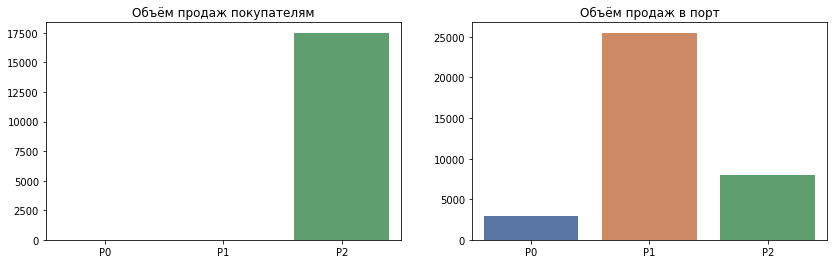

In [92]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharex=True)

sumVolPrice = []
for i in range(NProds):
    sumVolPrice.append(DecisionVolPrice.values[:,i].sum())
    
sns.barplot(x=DecisionVolPrice.columns,
            y=sumVolPrice,
            palette="deep",
            ax=axes[0]).set_title('Объём продаж покупателям')

sns.barplot(x=DecisionVolPrice.columns,
            y=VolPricePort[:,0],
            palette="deep",
            ax=axes[1]).set_title('Объём продаж в порт')

plt.show()

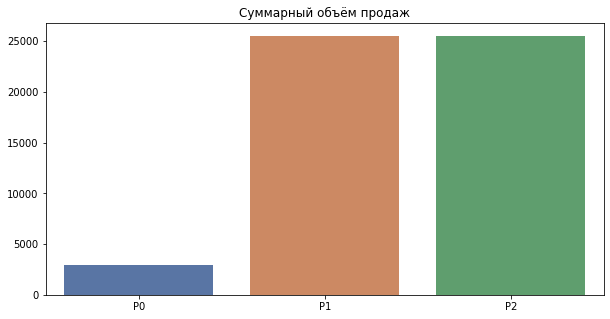

In [93]:
plt.figure(figsize=(10,5))
sumBuyPort = list(np.array(sumVolPrice)+np.array(VolPricePort[:,0]))
sns.barplot(x=DecisionVolPrice.columns,
            y=sumBuyPort,
            palette="deep").set_title('Суммарный объём продаж')


plt.show()

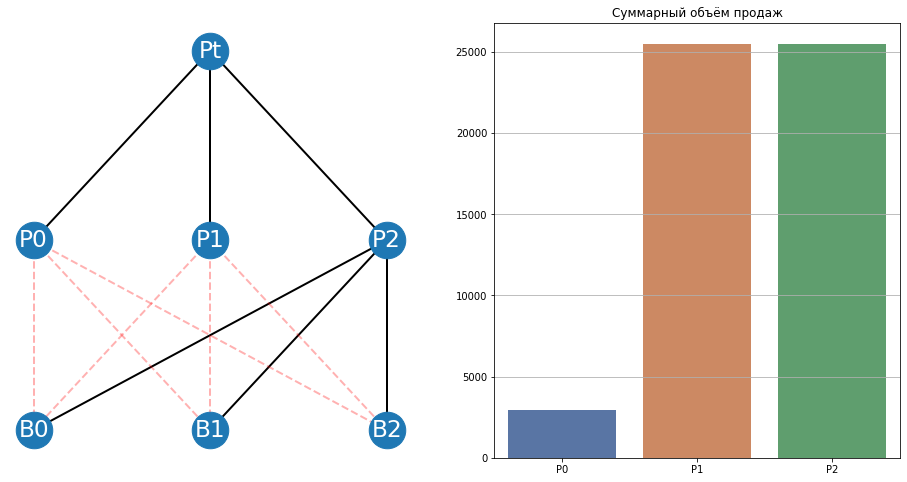

In [94]:
G = nx.Graph()
#Морской порт
for p in ProdIndex:
    G.add_edge(p, 'Pt', w=DecisionVolPort[p]['Pt'])
    
#Продавцы / покупатели
for b in BuyIndex:
    for p in ProdIndex:
        G.add_edge(p, b, w=DecisionVolPrice[p][b])

nodeKeys = []
nodePos = []
num_buy = 0
num_prod = 0
for p in ProdIndex:
        x_prod = int(-NProds/2)+num_prod
        num_prod+=1
        nodeKeys.append(p)
        nodeKeys.append('Pt')
        
        nodePos.append([x_prod,1])
        nodePos.append([0,2])
        
for b in BuyIndex:
    num_prod = 0
    x_buy = int(-NBuyers/2)+num_buy
    num_buy+=1
    for p in ProdIndex:
        x_prod = int(-NProds/2)+num_prod
        num_prod+=1
        nodeKeys.append(p)
        nodeKeys.append(b)
        
        nodePos.append([x_prod,1])
        nodePos.append([x_buy,0])       
        
pos = dict(zip(nodeKeys, nodePos))        
    
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['w'] > 0]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['w'] == 0]


plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)

#nodes_color = ('darkmagenta', 'darkblue', ['darkmagenta']*(NProds-1),'darkgreen','darkgreen','darkgreen','darkgreen','darkgreen')
#nodes_size = (p1, 2500, p2, p3, 2500, 2500, 2500, 2500)
nx.draw_networkx_nodes(G, pos=pos, node_size=4000/((NProds+NBuyers)/2))

nx.draw_networkx_edges(G, pos=pos, edgelist=elarge, width=2, edge_color='black')

nx.draw_networkx_edges(G, pos=pos, edgelist=esmall, width=2, alpha=0.3, edge_color='red', style='dashed')

edge_values = []
for (u, v, d) in G.edges(data=True):
    if d['w']>0:
        edge_values.append(int(d['w']))
        
labels = dict(zip(elarge, edge_values))

#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels, font_size=12, font_color='black')

# labels
nx.draw_networkx_labels(G, pos=pos, font_size=70/((NProds+NBuyers)/2), font_color='white')

plt.axis('off')
plt.subplot(1,2,2)
plt.grid(True)
sns.barplot(x=DecisionVolPrice.columns,
            y=sumBuyPort,
            palette="deep").set_title('Суммарный объём продаж')

#plt.axis('off')
#print(boldText+'Визуализация модели\n')
plt.show()